# COGS 108 - Final Project 

In [1]:
#!!!!!REMEMBER to delete this cell!!!!!#
my_key = 'oma_8jr25j-HQlsLpngaKgHDkUE3JoWIimQIR9CEDM62qxk8oa-b3IH2XtbKxcVwtp0ucE4YohDKiIWPZok43JCE3Fj5hvg72HKh-gdThc6wU6Nj3wBp_ESPHhDXX3Yx'

# Overview

*3-4 sentences summarizing the project and the results*

In this project, I will: 
-find the reviews for the hotels all the parks in San Diego; then I will do a sentiment analysis on them, relate that analysis to the budget spent on these parks every year to see if spending more on parks improves overall experience of hotels

# Name & GitHub ID

- Name: Yu Pan
- GitHub Username: mikeheheda

# Research Question

*In order to help out the local economy, should the Parks Department higher their budget to create better experiences for local hotels? In other words, is a higher budget for the Parks Department correlated to better Yelp reviews for hotels that are close to the parks?*

## Background and Prior Work

As the coronavirus wreaks havoc on the US' economy, I am wondering if the San Diego Parks and Recreation Department should be granted a higher budget to create better park experiences, and thus help local business attract more customers. I am looking for a correlation between higher budget and better Yelp reviews on local business(specifically hotels). While I cannot find any study that directly address this correlation, I do find many benefits that parks can bring to the local economy. 

According to WeConserve PA(1), a conservation community based in Pennsylvania, good parks attracts tourists to improve local economy. Homebuyers prefer purchasing properties near parks, which increases government tax income and local population, bringing in more business, further improing the economy. A case study demonstrates the benefits brought by the Balboa Park(2). Conducted by San Diego State University and Balboa Parj Conservancy, the *Balboa Park Benefits Study* concludes that the park alone brings an annual economic impact of 354.6 million dollars, which includes tourist lodging, food, shopping, etc. Moreover, it highlights that these non-local travelers occupy over 300 thousand hotel room nights and brings in 3.2 million dollars in sales tax. 

In a nutshell, a well-maintained parks system can generate significant economic impacts to the local economy. I am set to observe this impact on a micro scale, which is to find a correlation between the budget of the Parks Department and the reviews of local business on Yelp.

References (include links):
- 1)WeConserve PA - the Economic Benefits of Parks: https://conservationtools.org/guides/98-economic-benefits-of-parks
- 2)SDSU - Balboa Park Benefits Study: https://balboaparkconservancy.org/wp-content/uploads/2017/09/Balboa-Park-Benefits-Study-2017.pdf

# Hypothesis


Since I am looking for a relationship between the Parks spending and the quality of experiences of local hotels, I propose the alternative hypothesis: 

H<sub>1</sub>: A higher budget for the San Diego Parks Department significantly correlates with better overall Yelp reviews for hotel that are relevant to the parks.

and the null hypothesis:

H<sub>0</sub>: No correlation exists between the change in San Diego Parks Departments' budget and better overall Yelp reviews for local hotels.

# Datasets

To analyze the parks influence on the hotels, I need to find the reviews of businesses that are most relevant to these parks. The best way to achieve this is to conduct a search through the Yelp API to first find out what these businesses are, then find their reviews. 

Ideally, I would like to get equal numbers of reviews from each year(e.g. two reviews from each year, each business). However, because the Yelp API does not allow me to filter reviews according to their published time, I will get different number of reviews from each year. 

Dataset 1: 
- Dataset Name: Operating Actuals dataset
- Link to the dataset: http://seshat.datasd.org/budget/actuals_operating_datasd.csv
- Number of observations: 454891

This dataset provides the budget details of the Parks Department.

Dataset 2: 
- Dataset Name: Parks locaton dataset
- Link to the dataset: http://seshat.datasd.org/sde/parks/parks_datasd.geojson
- Number of observations: 2769

This dataset provides the name, area and location of each park in San Diego. The main purpose of this dataset is to help generate dataset 3.

Dataset 3: 
- Dataset Name: Business Reviews dataset
- Link to the dataset:(acquired through yelp API) https://api.yelp.com/v3/businesses/{id}/reviews 
- Number of observations: -

This dataset provides reviews of local hotels and will be used for sentiment analysis

### My plan for the datasets:
- From the <b>parks locaton dataset</b>, I will generate a list of names of all parks in San Diego
    - Using the park names and the Yelp API, I will generate a <b>list of hotels</b> most revelant to these parks
        - Then, I will extract the <b>reviews for all these hotels</b> and do a sentiment analysis to detect any overall year-to-year changes in attitude. 
- Using the <b>Operating Actuals dataset</b>, I will find the Parks department budget for the past few years
- Last, I will correlate significant changes in the budget to the changes in overall attitude

# Setup

In [49]:
#import the tools require for using API
import requests
import io

#for sentiment analysis, import VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

#import an inflation calculator developed by LA Times
import cpi

#import pandas, numpy, matplotlib, and seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning

Load dataset 1 and 2; and store them in variables

In [3]:
#Acquire and store operating actuals dataset in df_opr_act as dataframe
opr_act_url = 'http://seshat.datasd.org/budget/actuals_operating_datasd.csv'
opr_act = requests.get(opr_act_url).text
df_opr_act = pd.read_csv(io.StringIO(opr_act))

#Acquire and store parks location dataset in park_loc as json
park_loc_url = 'http://seshat.datasd.org/sde/parks/parks_datasd.geojson'
park_loc = requests.get(park_loc_url).json()


### Cleaning dataset 1:

Because I only plan to observe the differences of the Parks budget of each year, I will clean out the spending that does not belong to the parks department, and all columns except 'amount' and 'report_fy', storing all parks spending in df_budget.

In [142]:
#Drop observations that doesn't belong to the Parks Department
df_budget = df_opr_act[df_opr_act['dept_name'] == 'Parks & Recreation']

#Drop all other columns
df_budget = df_budget.drop(columns = ['fund_type', 'dept_name', 'funds_center_number', 'account', 'account_number', 'fund_number'])

#Rename the columns for clarity
df_budget = df_budget.rename(columns = {'report_fy': 'year'})

#Calculate the sum of each years' budget
df_budget = df_budget.groupby('year').agg(np.sum)

#Take a look
df_budget

,amount
year,
11,1.819405e+08
12,1.965323e+08
13,2.018419e+08
14,2.169659e+08
15,2.236179e+08
16,2.262815e+08
17,2.442289e+08
18,2.630864e+08
19,2.652765e+08


### Generating dataset 3 (Business Reviews dataset):
First, trim and transform information in dataset 2 from json to dataframe. 

In [5]:
#First trim the data in the json file for easy transformation
for feat in park_loc['features']: 
    del feat['type']
    del feat['geometry']

#Transform the json file to dataframe
df_park = pd.DataFrame.from_dict(park_loc['features'])
df_park = df_park['properties'].apply(pd.Series)

#Have a glimpse
df_park

,objectid,name,alias,gis_acres,park_type,location,owner
0,1,South Carlsbad SB,South Carlsbad State Beach,115.895878,State,,State Parks
1,2,Torrey Pines SB,Torrey Pines State Beach,67.294309,State,,State Parks
2,3,Ruocco Park,Ruocco Park,3.312526,Local,"585 Harbor Ln, San Diego. California",SDUPD
3,4,Tuna Harbor Park,Tuna Harbor Park,0.639035,Local,"700 North Harbor Dr, San Diego. California",SDUPD
4,5,San Diego Bayfront Park,San Diego Bayfront Park,3.669272,Local,"One Park Boulevard, San Diego. California",SDUPD
...,...,...,...,...,...,...,...
2764,2765,San Luis Rey River Park,San Luis Rey River Park,712.262117,Open Space,"5521 W. Lilac Road, Bonsall, CA 92003",County DPR
2765,2766,Horse Creek Ridge Sports Park,Horse Creek Ridge Sports Park,8.398529,Local,"240 Gold Palomino Way, Fallbrook CA, 92028",County DPR
2766,2767,,Harmony Grove Village 4th of July Park,2.510408,Local,"2815 STARRY NIGHT DR, Escondido, CA 92029",County DPR
2767,2768,Harmony Grove Community Park,Harmony Grove Village Community Park,3.575260,Local,"2982 Harmony Grove Road, Escondido, CA 92029",County DPR


Cleaning database 2: 
- Remove unnecessary columns
- Remove parks marked as 'open spaces':
    - their main purpose is to provide utility to citizens, not to attract tourists/businesses
    - doing so also considerably shrinks the dataset so that later I don't drown the Yelp server with calls.

In [6]:
#Remove all parks of 'Open Spaces'
df_park = df_park.drop(df_park.loc[df_park['park_type'] == 'Open Space'].index)

#Remove all columns except 'name'
df_park = df_park.drop(columns = ['objectid', 'alias', 'gis_acres', 'location', 'owner', 'park_type'])

#Remove observations with null values
df_park = df_park.dropna()

#Reset the index for later convenience
df_park = df_park.reset_index()
df_park = df_park.drop(columns = ['index'])

#Have a peek
df_park

,name
0,South Carlsbad SB
1,Torrey Pines SB
2,Ruocco Park
3,Tuna Harbor Park
4,San Diego Bayfront Park
...,...
809,Fallbrook Local
810,Horse Creek Ridge Sports Park
811,
812,Harmony Grove Community Park


Next, using this list of parks names, I will write a function to conduct a search for nearby businesses using the Yelp API. 

In [7]:
#This function takes in the name of a park, and return a list of the names of four nearby hotels
def business_search(park_name): 
    ENDPOINT = 'https://api.yelp.com/v3/businesses/search'
    PARAMS = {'term' : 'hotel', 
                'location' : park_name,
                'limit' : 4}
    HEADERS = {'Authorization' : 'bearer %s' % my_key}
    result = requests.get(url = ENDPOINT, params = PARAMS, headers = HEADERS).json()
    
    id_list = []
    if 'businesses' in result: 
        for i in range(0, len(result['businesses'])): 
            business_id = result['businesses'][i]['id']
            id_list.append(business_id)

    return(id_list)

Apply the function above to df_park to generate a new column containing the hotels' information. This will send len(df_park)=814 calls through the API. 

In [8]:
#Apply business_search()
df_park['business_ids'] = df_park.apply(business_search, axis = 1)

#Have a look
df_park

,name,business_ids
0,South Carlsbad SB,"[9BrkzQOfu6GAZyYsrqAipw, VUlBPsKhiq_P4m7dT3CU8..."
1,Torrey Pines SB,"[0UybSwB__8hwhhAwiWRMRw, u--tk5RCV10hw0-XR1N67..."
2,Ruocco Park,"[mH6PPaJ2i1ZCAs0aXxY4BQ, levkSWPb0kXwBIb8pgGXb..."
3,Tuna Harbor Park,"[mH6PPaJ2i1ZCAs0aXxY4BQ, levkSWPb0kXwBIb8pgGXb..."
4,San Diego Bayfront Park,"[mH6PPaJ2i1ZCAs0aXxY4BQ, UrYZeABzGVtrr_MqzoFG-..."
...,...,...
809,Fallbrook Local,"[TR_sqedNf0g-YnBk30F4GQ, gBXK1HFn4qADS9ACAexYr..."
810,Horse Creek Ridge Sports Park,"[Pv3Edn525LExKKrTW__JSA, lShZUc-YcUXXK4X46Aqcq..."
811,,[]
812,Harmony Grove Community Park,"[uh_eOuK0re7uGCx33NSVFg, Rqd9zxSGV1eJlJR3Z4cCy..."


Because some parks are close to each other, some of these hotels might show up twice on the list; therefore, it is necessary to clean the data and store it in a list called bus_id_lst. 

In [9]:
#First, merge all the businesses into a list
b_list = []
for i in range(1,len(df_park)): 
    b_list += df_park['business_ids'][i]
print('The number of results returned from the search: ' + str(len(b_list)))

#Eliminate any repetition in the business ID list
bus_id_lst = []
for ind in b_list: 
    if ind not in bus_id_lst: 
        bus_id_lst.append(ind)
print('The actual number of hotels in the result: ' + str(len(bus_id_lst)))

The number of results returned from the search: 3147
The actual number of hotels in the result: 1458


Using this list of hotels, the last step is to extract all the comments from yelp, and save them in a new dataframe with their comment id, rating number and comment year. 

In [10]:
#Turns the 'time_created'(str) to the year(int) that it is created
def year_of(time): 
    return(int(time[2:4]))

#Returns a dataframe containing information about the comments
def review_of(id_list): 
    review_list = pd.DataFrame(columns = ['id', 'year', 'content'])
    for id in id_list: 
        ENDPOINT = 'https://api.yelp.com/v3/businesses/' + id + '/reviews'
        HEADERS = {'Authorization' : 'bearer %s' % my_key}
        result = requests.get(url = ENDPOINT, headers = HEADERS).json()

        if 'reviews' in result: 
            for num in range(0, len(result['reviews']) - 1): 
                rvw_id = result['reviews'][num]['id']
                rvw_time = result['reviews'][num]['time_created']
                rvw_text = result['reviews'][num]['text']

                x = {'id': rvw_id, 'year': year_of(rvw_time), 'content': rvw_text}
                review_list = review_list.append(x, ignore_index = True)
    return(review_list)

Apply the function above to the list of businesses

In [169]:
#Apply review_of()
df_reviews = review_of(bus_id_lst)

#take a peek
df_reviews

,id,year,content
0,DUqNxY2FlRvf_Z664wc94A,20,Wow! This Inn is a secret gem in Del Mar! The ...
1,rIt1x6VEHAncTtC2OxL6aQ,19,Very good location and in-house Peruvian resta...
2,kf5qv-hQgcGXptrlZeY3-A,20,This is a great little hotel for families and ...
3,Fpp6H8cjpjTgbZzXnp2r1g,20,Stayed here for a night while on a single day ...
4,68hAnkfXUVELLEyrekyVlg,20,We had the loveliest stay here. I'll admit I w...
...,...,...,...
2750,Ew2J1QtWx0rg-rkdGrDgxA,20,"Good location, helpful staff with covid requir..."
2751,Ps8i5EzF8A7lB0l_8HX9LQ,20,The rooms are really nice and feel like a high...
2752,zXTmagKpT1wsqrnKtN58PA,20,I gave it two tries and won't be coming back. ...
2753,18k8TBctLC3SDnowuYZaLg,20,We stayed here tonight and had an excellent st...


# Data Analysis & Results

Ideally, assuming that the budget is increasing at a constant rate, the reviews of hotels should stay the same; if the increase rate of a particular year is low, I expect the review of that year to be relatively negative, and vice versa. 

So, in the following analysis, I will find the annual increase rate of the Parks department's budget, and the polarity score of Yelp reviews by year, and find if there is any correlation between the change of these two variable. 

### Budget analysis:

First, let's take a better look at how the budget changes over the years

<AxesSubplot:xlabel='year', ylabel='amount'>

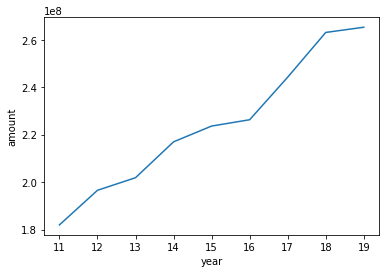

In [74]:
sns.lineplot(data = df_budget, x = 'year', y = 'amount')

As you can see, the budget seems to grow steadily over the yars, however, this does not reflect a real increase when we look from an economics perspective. To detect how much is really increasing, the budget must be adjusted for inflation.  

Here I am using a free API named cpi.inflation() developed by LA times, here is a link to the Github page containing their source code: https://github.com/datadesk/cpi

In [149]:
#Add a new column to df_budget that adjusts the dollar amount to inflation
df_budget['adjusted_amount'] = np.nan
for i in range(11,19): 
    df_budget['adjusted_amount'][i] = cpi.inflate(df_budget['amount'][i], i+2000)

#because 2019 CPI is not yet included in the database, it will not be adjusted
df_budget['adjusted_amount'][19] = df_budget['amount'][19]

#take a look at the new table
df_budget

,amount,adjusted_amount
year,,
11,1.819405e+08,2.031064e+08
12,1.965323e+08,2.149474e+08
13,2.018419e+08,2.175677e+08
14,2.169659e+08,2.301367e+08
15,2.236179e+08,2.369113e+08
16,2.262815e+08,2.367468e+08
17,2.442289e+08,2.501941e+08
18,2.630864e+08,2.630864e+08
19,2.652765e+08,2.652765e+08


<AxesSubplot:xlabel='year'>

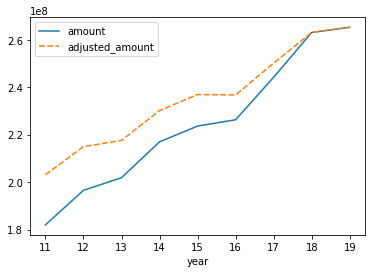

In [154]:
#unadjusted(solid) vs adjusted(dash) budget visualized
sns.lineplot(data = df_budget)

In [159]:
#calculate the annual increase rate of each year and store in new column
df_budget['increase_rate'] = np.nan
for i in range(12,19): 
    df_budget['increase_rate'][i] = (df_budget['amount'][i]/df_budget['amount'][i-1] - 1)

#take a look at the new table
df_budget

,amount,adjusted_amount,increase_rate
year,,,
11,1.819405e+08,2.031064e+08,NaN
12,1.965323e+08,2.149474e+08,0.080201
13,2.018419e+08,2.175677e+08,0.027016
14,2.169659e+08,2.301367e+08,0.074930
15,2.236179e+08,2.369113e+08,0.030659
16,2.262815e+08,2.367468e+08,0.011912
17,2.442289e+08,2.501941e+08,0.079314
18,2.630864e+08,2.630864e+08,0.077213
19,2.652765e+08,2.652765e+08,NaN


<AxesSubplot:xlabel='year', ylabel='increase_rate'>

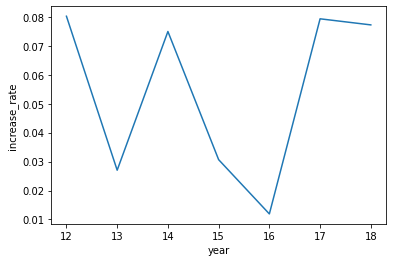

In [161]:
#plot the annual increase rate(the percentage increased from the previous year)
sns.lineplot(data = df_budget['increase_rate'])

### Sentiment analysis:
Using VADER, I will do a sentiment analysis on review list to obtain the polarity scores for the reviews, and view them by year. 

First, let's look at how many reviews there are from each year, years with particularly low numbers 

In [170]:
df_reviews['year'].value_counts()

20    1743
19     548
18     224
17      93
16      59
15      44
14      15
13      13
12       6
11       5
8        3
10       1
9        1
Name: year, dtype: int64

next, I will define a function to obtain the polarity scores of a list reviws and store them in a dataframe. 

In [198]:
def get_comp_score(rvw_lst): 

    df_score = pd.DataFrame()
    analysis = {}

    for sentence in rvw_lst: 
        analysis['compound'] = analyser.polarity_scores(sentence)['compound']
        df_score = df_score.append(analysis, ignore_index = True)

    return(df_score) 

Now, find the polarity scores of years 2015 to 2019 and store them inside a dataframe

In [210]:
#get compound polarity score of each year
rvw_score_19 = get_comp_score(df_reviews.loc[df_reviews['year'] == 19]['content'])['compound'].mean()
rvw_score_18 = get_comp_score(df_reviews.loc[df_reviews['year'] == 18]['content'])['compound'].mean()
rvw_score_17 = get_comp_score(df_reviews.loc[df_reviews['year'] == 17]['content'])['compound'].mean()
rvw_score_16 = get_comp_score(df_reviews.loc[df_reviews['year'] == 16]['content'])['compound'].mean()
rvw_score_15 = get_comp_score(df_reviews.loc[df_reviews['year'] == 15]['content'])['compound'].mean()
rvw_score_14 = get_comp_score(df_reviews.loc[df_reviews['year'] == 14]['content'])['compound'].mean()
rvw_score_13 = get_comp_score(df_reviews.loc[df_reviews['year'] == 13]['content'])['compound'].mean()

#store polarity score of each year in to a dataframe
df_rvw_score = pd.DataFrame(data = {'score': [np.nan, np.nan, rvw_score_13, rvw_score_14,rvw_score_15,rvw_score_16,rvw_score_17,rvw_score_18,rvw_score_19]}, index = [11, 12, 13,14,15,16,17,18,19])
df_rvw_score.index.name = 'year'

#check data
df_rvw_score

,score
year,
11,NaN
12,NaN
13,0.702069
14,0.521393
15,0.492014
16,0.566595
17,0.481198
18,0.484598
19,0.471278


### Putting it together: 

Lastly, I am putting the San Diego Parks and Recreation Department's annual budget increase rate anf the compound polarity scores of Yelp reviews onto the same plot to see if there is any obvious correlation.  

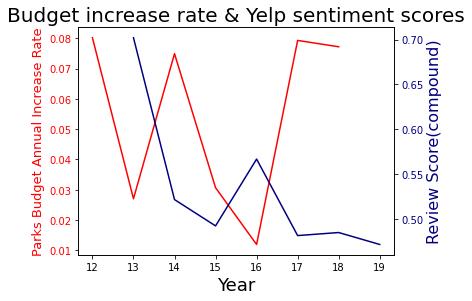

In [220]:
x = np.arange(11, 20, 1)
fig, ax1 = plt.subplots()

color1 = 'red'
ax1.set_xlabel('Year', size = 18)
ax1.set_ylabel('Parks Budget Annual Increase Rate', color = color1, size = 13)
ax1.plot(x, df_budget['increase_rate'], color = color1)
ax1.tick_params(axis='y', labelcolor = color1)

ax2 = ax1.twinx()

color2 = 'navy'
ax2.set_ylabel('Review Scores(compound)', color = color2, size = 16)
ax2.plot(x, df_rvw_score['score'], color = color2)
ax2.tick_params(axis='y', labelcolor = color2)

fig.tight_layout()
plt.title('Budget increase rate & Yelp sentiment scores', fontsize = 20)
plt.show()

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*